# Classificação de Sinais de Trânsito com HOG e SVM

Um projeto de Visão Computacional para classificar 43 tipos de sinais de trânsito alemães utilizando um pipeline clássico com o descritor HOG e o classificador SVM.

## Dataset

O projeto utiliza o **GTSRB (German Traffic Sign Recognition Benchmark)**, uma base de dados pública e desafiadora que contém mais de 50.000 imagens de 43 classes de sinais de trânsito alemães. As imagens foram capturadas em diversas condições de iluminação e perspetiva, tornando-a ideal para treinar e validar modelos robustos. A fim de garantir agilidade e performance, foram utilizados 39.209 dados para construir esse pipeline.

O dataset pode ser encontrado no Kaggle:
[GTSRB - German Traffic Sign Recognition](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign-recognition-benchmark)

Este projeto é interessante porque ensina a construir um sistema completo de inteligência artificial para resolver um desafio prático e visual do mundo real: permitir que computadores reconheçam sinais de trânsito como um carro autônomo faria.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [ ]:
import os

# Lista o conteúdo do diretório baixado para inspecionar a estrutura de pastas
print(os.listdir(path))

['Meta', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'test', 'Train', 'train']


Iniciando o script. Usando o diretório: /kaggle/input/gtsrb-german-traffic-sign/Train

--- Processamento Concluído! ---
Total de imagens carregadas: 39209
Total de rótulos carregados: 39209
Formato do array de imagens: (39209, 64, 64)
Formato do array de rótulos: (39209,)

Exibindo uma imagem de exemplo para verificação...


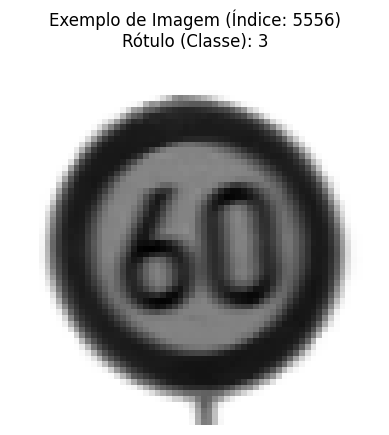

In [ ]:
# Importação das bibliotecas necessárias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


try:
    # Tenta usar a variável 'path'
    # Se 'path' não estiver definida, vai gerar um NameError, tratado abaixo.
    caminho_dataset = os.path.join(path, 'Train')
except NameError:
    # Se a variável 'path' não existir, pede ao usuário para definir o caminho manualmente.
    print("Variável 'path' não encontrada.")
    caminho_dataset = 'COLOQUE/O/CAMINHO/COMPLETO/PARA/A/PASTA/gtsrb-german-traffic-sign/AQUI'


print(f"Iniciando o script. Usando o diretório: {caminho_dataset}")

# Define um tamanho padrão para todas as imagens
tamanho_imagem = (64, 64)

# Listas para armazenar os dados
imagens = []
rotulos = []

# LÓGICA DE CARREGAMENTO
if not os.path.exists(caminho_dataset):
    print(f"ERRO: O caminho '{caminho_dataset}' não foi encontrado.")
    print("Por favor, verifique a variável 'path' ou o caminho manual.")
else:
    # Itera sobre as pastas de cada classe (0, 1, 2, ...)
    pastas_classes = sorted([int(d) for d in os.listdir(caminho_dataset) if os.path.isdir(os.path.join(caminho_dataset, d)) and d.isdigit()])

    for classe_id in pastas_classes:
        caminho_classe = os.path.join(caminho_dataset, str(classe_id))

        for nome_arquivo in os.listdir(caminho_classe):
            # Verifica por ficheiros .png E .ppm
            if nome_arquivo.endswith(('.png', '.ppm')):
                caminho_imagem = os.path.join(caminho_classe, nome_arquivo)

                # Usa cv2.imread que é padrão para pipelines de CV
                imagem = cv2.imread(caminho_imagem)

                if imagem is not None:
                    # Pré-processamento: Converter para escala de cinza (OpenCV lê em BGR)
                    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

                    # Pré-processamento: Redimensionar para o tamanho padrão
                    imagem_redimensionada = cv2.resize(imagem_cinza, tamanho_imagem)

                    # Adicionar a imagem e o rótulo às nossas listas
                    imagens.append(imagem_redimensionada)
                    rotulos.append(classe_id)

    # VERIFICAÇÃO FINAL
    imagens = np.array(imagens)
    rotulos = np.array(rotulos)

    print("\n--- Processamento Concluído! ---")
    print(f"Total de imagens carregadas: {len(imagens)}")
    print(f"Total de rótulos carregados: {len(rotulos)}")

    if len(imagens) > 0:
      print(f"Formato do array de imagens: {imagens.shape}")
      print(f"Formato do array de rótulos: {rotulos.shape}")
      print("\nExibindo uma imagem de exemplo para verificação...")

      indice_aleatorio = np.random.randint(0, len(imagens))
      plt.imshow(imagens[indice_aleatorio], cmap='gray')
      plt.title(f"Exemplo de Imagem (Índice: {indice_aleatorio})\nRótulo (Classe): {rotulos[indice_aleatorio]}")
      plt.axis('off')
      plt.show()
    else:
      print("\nNenhuma imagem foi carregada. Verifique a estrutura das pastas e os formatos dos ficheiros.")

# EXTRAÇÃO DE CARACTERÍSTICAS


Iniciando: Extração de Características HOG...

--- Extração HOG Concluída! ---
Formato do array de características HOG: (39209, 1764)

Exibindo um exemplo de imagem original e sua representação HOG...


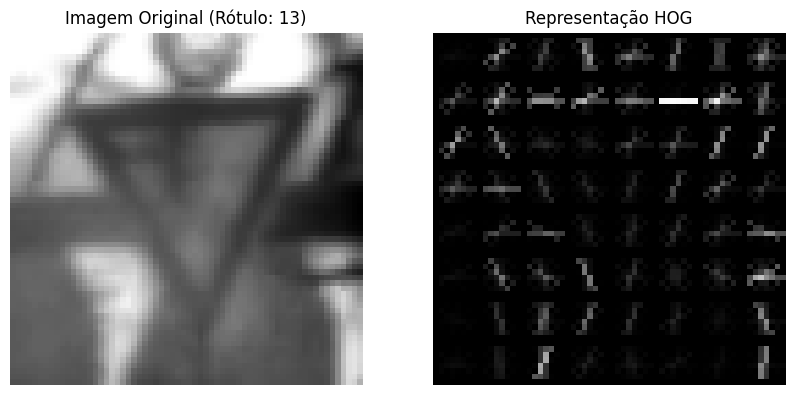

In [ ]:

# Importação da função 'hog' da biblioteca scikit-image
from skimage.feature import hog

print("\n========================================================")
print("Iniciando: Extração de Características HOG...")


# Lista para armazenar os vetores de características HOG de cada imagem
hog_features = []

# Lista para armazenar as imagens HOG para podermos visualizá-las
hog_images = []

# Parâmetros do HOG. Estes valores são um bom ponto de partida e podem ser ajustados.
# - orientations: Número de "fatias" no nosso histograma de direções. 9 é comum.
# - pixels_per_cell: O tamanho de cada célula (em pixels) para análise.
# - cells_per_block: O tamanho de cada bloco (em células) para normalização da iluminação.
pixels_por_celula = (8, 8)
celulas_por_bloco = (2, 2)

# Itera sobre cada imagem (em escala de cinza e redimensionada) que carregamos
for imagem in imagens:
    # A função hog retorna duas coisas: o vetor de características e uma imagem para visualização
    features, hog_image = hog(imagem,
                              orientations=9,
                              pixels_per_cell=pixels_por_celula,
                              cells_per_block=celulas_por_bloco,
                              visualize=True,
                              block_norm='L2-Hys') # Técnica de normalização popular

    # Adiciona os resultados às nossas listas
    hog_features.append(features)
    hog_images.append(hog_image)

# Converte a lista de características para um array NumPy
hog_features = np.array(hog_features)

print("\n--- Extração HOG Concluída! ---")
# O formato será (n_imagens, tamanho_do_vetor_hog)
# Para os parâmetros atuais, o tamanho do vetor será 1764
print(f"Formato do array de características HOG: {hog_features.shape}")


# --- Visualização do HOG ---
# É muito útil ver o que o HOG está a "enxergar".
# Vamos mostrar uma imagem original ao lado da sua representação HOG.
if len(hog_images) > 0:
    print("\nExibindo um exemplo de imagem original e sua representação HOG...")

    # Escolhe um índice aleatório para exibir
    indice_aleatorio = np.random.randint(0, len(imagens))

    # Cria uma figura com dois subplots (um ao lado do outro)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(imagens[indice_aleatorio], cmap='gray')
    ax1.set_title(f'Imagem Original (Rótulo: {rotulos[indice_aleatorio]})')

    ax2.axis('off')
    ax2.imshow(hog_images[indice_aleatorio], cmap='gray')
    ax2.set_title('Representação HOG')

    plt.show()

# TREINAMENTO DO CLASSIFICADOR E AVALIAÇÃO

In [ ]:
# Importação das bibliotecas de Machine Learning do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

print("\n========================================================")
print("Iniciando o Passo 4: Treinamento e Avaliação do Modelo...")

# DIVISÃO DOS DADOS em treino e teste
#   - X: são as características (features), no nosso caso, os vetores HOG.
#   - y: são os rótulos (labels), as classes de cada sinal.
#   - test_size=0.2: significa que separamos 20% dos dados para o conjunto de teste.
#   - random_state=42: garante que a divisão seja sempre a mesma, para resultados reprodutíveis.
X_train, X_test, y_train, y_test = train_test_split(
    hog_features,
    rotulos,
    test_size=0.2,
    random_state=42,
    stratify=rotulos # Importante para manter a proporção de classes nos dois conjuntos
)

print(f"\nDados divididos em treino e teste:")
print(f" - {len(X_train)} amostras para treino.")
print(f" - {len(X_test)} amostras para teste.")


Iniciando o Passo 4: Treinamento e Avaliação do Modelo...

Dados divididos em treino e teste:
 - 31367 amostras para treino.
 - 7842 amostras para teste.


In [ ]:
# TREINAMENTO DO CLASSIFICADOR SVM
# Usamos o LinearSVC, uma implementação de SVM otimizada para casos como o nosso.
print("\nTreinando o classificador LinearSVC...")
print("Este processo pode levar alguns minutos. Por favor, aguarde.")

# Cria o modelo. O parâmetro C é de regularização, 1.0 é um bom valor padrão.
# Aumentar max_iter pode ser necessário se o modelo não convergir.
model = LinearSVC(C=1.0, max_iter=5000, random_state=42, tol=1e-4)

# Treina o modelo com os dados de TREINO.
model.fit(X_train, y_train)

print("\n--- Treinamento Concluído! ---")


Treinando o classificador LinearSVC...
Este processo pode levar alguns minutos. Por favor, aguarde.

--- Treinamento Concluído! ---


In [ ]:
# AVALIAÇÃO DO MODELO
print("\nRealizando predições no conjunto de teste...")

# Pede ao modelo para prever os rótulos para os dados de TESTE
y_pred = model.predict(X_test)

print("--- Avaliação Concluída! ---")

# CALCULAR AS MÉTRICAS
# Acurácia: Porcentagem geral de acertos.
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do modelo: {accuracy * 100:.2f}%")

# Relatório de Classificação: Mostra Precisão, Revocação e F1-Score para CADA classe.
# Isso é excelente para o seu relatório, pois mostra onde o modelo é bom e onde ele falha.
print("\n--- Relatório de Classificação Detalhado ---")
print(classification_report(y_test, y_pred))


Realizando predições no conjunto de teste...
--- Avaliação Concluída! ---

Acurácia do modelo: 96.98%

--- Relatório de Classificação Detalhado ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       0.93      0.91      0.92       444
           2       0.88      0.90      0.89       450
           3       0.94      0.94      0.94       282
           4       0.98      0.99      0.98       396
           5       0.89      0.90      0.90       372
           6       0.99      1.00      0.99        84
           7       0.94      0.92      0.93       288
           8       0.95      0.93      0.94       282
           9       0.99      0.99      0.99       294
          10       0.99      0.99      0.99       402
          11       0.96      0.98      0.97       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       0.99      1.00      0

### **Análise dos Resultados do Modelo**

Interpretando os principais resultados obtidos, fundamentais para embasar o relatório e a apresentação:

#### **Acurácia Geral (96,98%)**  
Esse valor indica que o modelo acertou a classificação de aproximadamente 97 em cada 100 sinais de trânsito no conjunto de teste. Refletindo uma performance bastante sólida.

#### **Relatório de Classificação Detalhado**  
O relatório de classificação oferece uma visão aprofundada sobre como o modelo se comporta em cada classe. Ele é essencial para identificar tanto os pontos fortes quanto os desafios do modelo.

#### **Classes com Alto Desempenho**  
Diversas classes apresentaram f1-score de 0.99 ou 1.00 (como as classes 12, 13, 17, 38, entre outras), indicando que o modelo realiza a detecção desses sinais com altíssima precisão. Esses são casos de sucesso, o que evidencia a capacidade do modelo em reconhecer certos padrões com excelência.

#### **Classes com Maior Desafio**  
Algumas classes demonstraram desempenho ligeiramente inferior, com f1-scores como:

- Classe 2: 0.89  
- Classe 5: 0.90  
- Classe 1: 0.92  

Esses resultados não comprometem a eficácia geral do modelo, mas sinalizam áreas que merecem atenção. As dificuldades podem estar relacionadas a semelhanças visuais entre sinais, variações de iluminação ou ângulo nas imagens do conjunto de dados.


-------------------------------------------------------------------------------------------------

Para podermos visualizar as imagens correspondentes aos resultados, precisamos de um pequeno ajuste no nosso passo de divisão de dados. Além de dividir os hog_features e rotulos, precisamos dividir também o array de imagens originais da mesma forma. Com este ajuste, teremos a variável images_test que contém as imagens originais correspondentes aos nossos resultados de teste.

In [ ]:
# AJUSTE: Adicionar 'imagens' à divisão de dados
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(
    hog_features,
    rotulos,
    imagens,
    test_size=0.2,
    random_state=42,
    stratify=rotulos
)


Iniciando Geração de exemplos visuais...

Total de acertos: 7605
Total de erros: 237

Exibindo alguns exemplos de classificações CORRETAS:


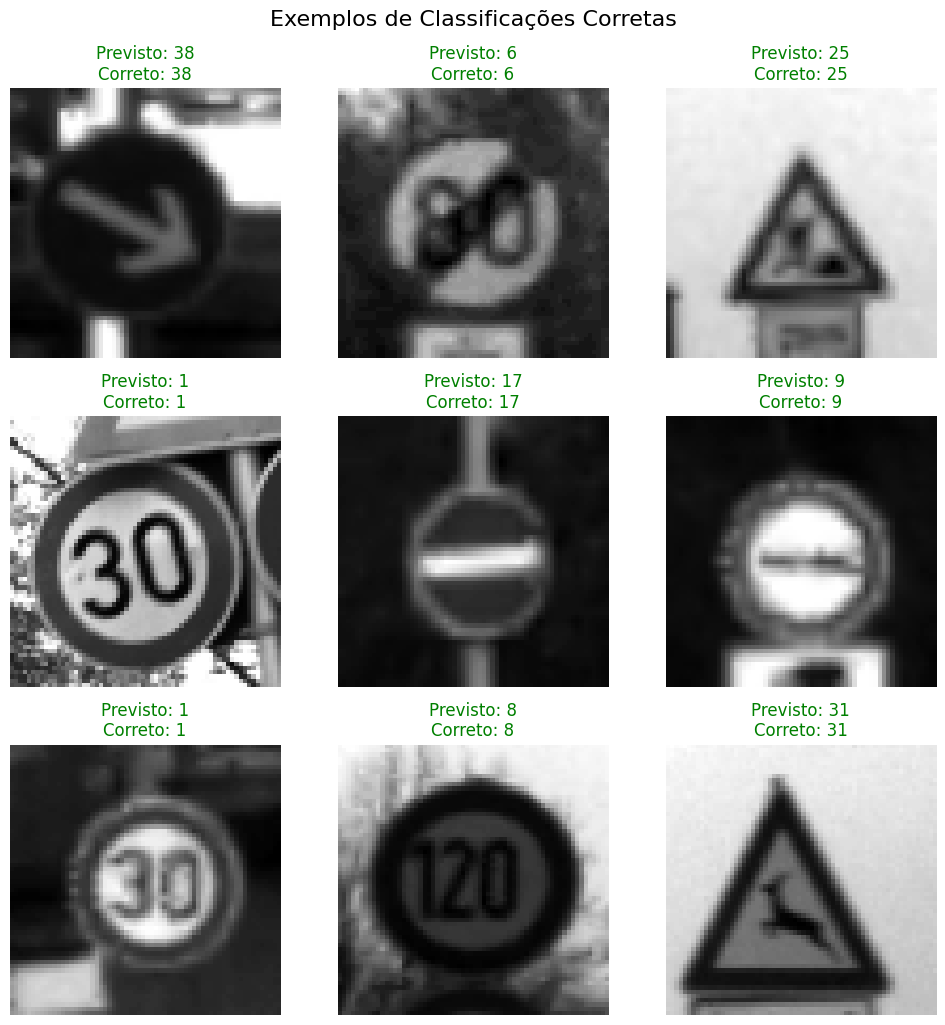


Exibindo alguns exemplos de classificações INCORRETAS:


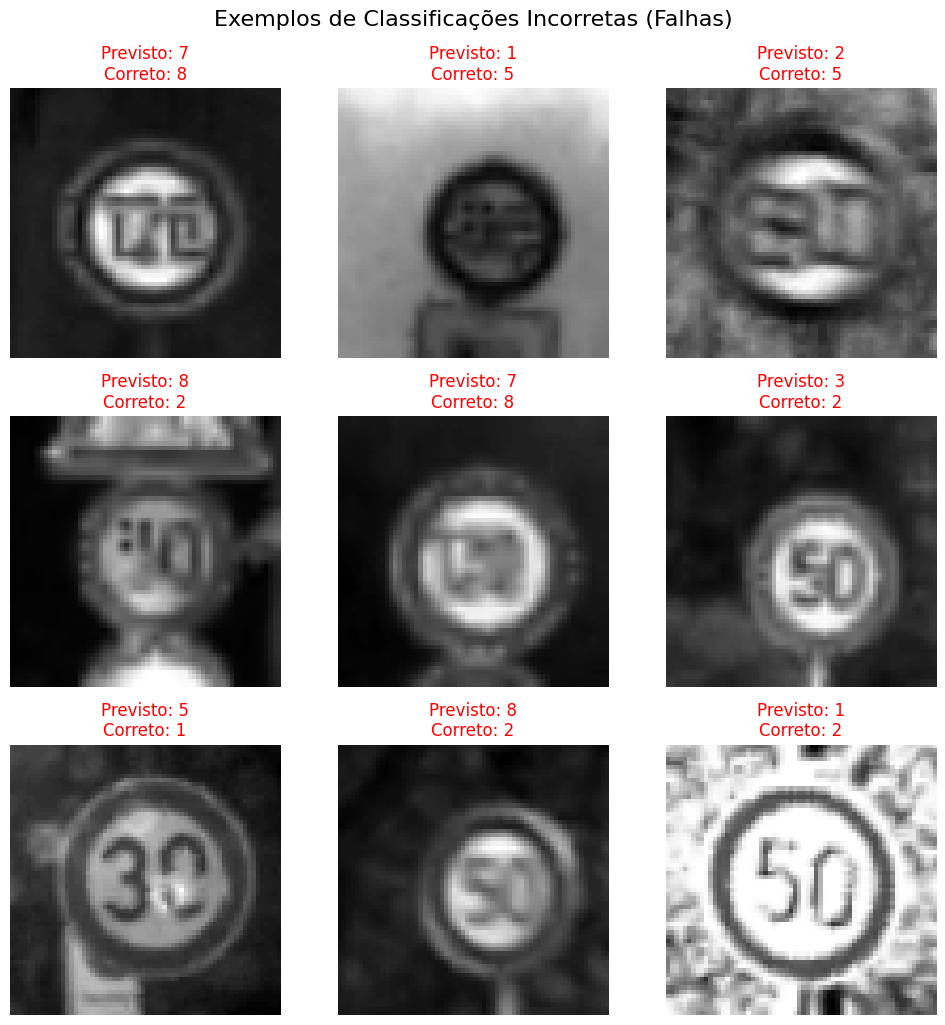

In [ ]:
# ANÁLISE VISUAL DE RESULTADOS

print("\n========================================================")
print("Iniciando Geração de exemplos visuais...")

# Encontrar os índices (as posições) dos acertos e dos erros
indices_corretos = np.where(y_pred == y_test)[0]
indices_incorretos = np.where(y_pred != y_test)[0]

print(f"\nTotal de acertos: {len(indices_corretos)}")
print(f"Total de erros: {len(indices_incorretos)}")


# VISUALIZAÇÃO DOS ACERTOS
print("\nExibindo alguns exemplos de classificações CORRETAS:")
fig_acertos, axes_acertos = plt.subplots(3, 3, figsize=(10, 10))
# Itera 9 vezes para preencher uma grade 3x3
for i, ax in enumerate(axes_acertos.flatten()):
    # Escolhe um índice aleatório da lista de acertos
    idx = np.random.choice(indices_corretos)

    ax.imshow(images_test[idx], cmap='gray')
    ax.set_title(f"Previsto: {y_pred[idx]}\nCorreto: {y_test[idx]}", color='green')
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Exemplos de Classificações Corretas", fontsize=16, y=1.02)
plt.show()


# VISUALIZAÇÃO DOS ERROS
print("\nExibindo alguns exemplos de classificações INCORRETAS:")
# Verifica se existem erros para exibir
if len(indices_incorretos) > 0:
    fig_erros, axes_erros = plt.subplots(3, 3, figsize=(10, 10))
    # Itera 9 vezes ou o número de erros, o que for menor
    num_erros_display = min(len(indices_incorretos), 9)

    for i in range(num_erros_display):
        ax = axes_erros.flatten()[i]
        # Escolhe um índice aleatório da lista de erros
        idx = np.random.choice(indices_incorretos)

        ax.imshow(images_test[idx], cmap='gray')
        ax.set_title(f"Previsto: {y_pred[idx]}\nCorreto: {y_test[idx]}", color='red')
        ax.axis('off')

    # Desativa eixos que não foram usados
    for j in range(num_erros_display, 9):
        axes_erros.flatten()[j].axis('off')

    plt.tight_layout()
    plt.suptitle("Exemplos de Classificações Incorretas (Falhas)", fontsize=16, y=1.02)
    plt.show()
else:
    print("Incrível! Não foram encontrados erros para exibir.")